Team Members:

- Vaibhav Falgun Shah AI23MTECH02007
- Raj Popat CS23MTECH14009
- Sreyash Mohanty CS23MTECH14015
- Yash Shukla CS23MTECH14018
- Somya Kumar SM23MTECH11010

In [203]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score

import matplotlib.pyplot as plt

from scipy.sparse.linalg import eigsh
from scipy.sparse import diags
from sklearn.metrics import silhouette_score

import warnings 
warnings.filterwarnings('ignore') 

In [95]:
df = pd.read_csv('payments.csv')
print(df)

        Sender  Receiver  Amount
0         1309      1011  123051
1         1309      1011  118406
2         1309      1011  112456
3         1309      1011  120593
4         1309      1011  166396
...        ...       ...     ...
130530    1344      1390   21739
130531    1914      1390    3374
130532    1914      1390    5186
130533    1914      1390    1559
130534    1914      1390    1997

[130535 rows x 3 columns]


We can observe that there exist multiple edges between same set of sender and receiver nodes. we keep them to have rich analysis of the graph

In [184]:
G = nx.from_pandas_edgelist(df,'Sender', 'Receiver', edge_attr='Amount')

In [220]:
def hyperparam_search_eps(X, eps_values, min_samples=5):
    scores = []

    for eps in eps_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
        else:
            score = -1
        
        scores.append((eps, score))

    best_eps, best_score = max(scores, key=lambda x: x[1])
    return best_eps, best_score, scores

# Function to perform hyperparameter tuning for KMeans
def optimal_kmeans_clusters(X, cluster_range):
    wcss = []  # Within-cluster sum of squares
    silhouette_scores = []
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        labels = kmeans.fit_predict(X)
        
        wcss.append(kmeans.inertia_)
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(-1)
    
    return wcss, silhouette_scores

def hyperparam_search(embedding, exp_name):
    eps_values = np.linspace(0.1, 10.0, 50)
    best_eps, best_score, scores = hyperparam_search_eps(embedding, eps_values)

    print(f"Hyperparameter search for {exp_name}:")

    print(f"Best eps value is: {best_eps} with silhouette score: {best_score}")
    eps_values, silhouette_scores_dbscan = zip(*scores)

    # Perform hyperparameter tuning for KMeans n_clusters
    cluster_range = range(2, 11)  # Testing 2 to 10 clusters
    wcss, silhouette_scores_kmeans = optimal_kmeans_clusters(embedding, cluster_range)

    plt.figure(figsize=(12, 10))

    ax3 = plt.subplot(212)
    ax2 = plt.subplot(221)
    ax1 = plt.subplot(222)

    ax1.plot(cluster_range, wcss, marker='o')
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("Within-Cluster Sum of Square")
    ax1.set_title("Elbow Curve (K-Means)")
    ax1.grid(True)

    ax2.plot(cluster_range, silhouette_scores_kmeans, marker='o')
    ax2.set_xlabel("Number of Clusters")
    ax2.set_ylabel("Silhouette Score")
    ax2.set_title("Silhouette Scores for different number of clusters (K-Means)")
    ax2.grid(True)

    ax3.plot(eps_values, silhouette_scores_dbscan, marker='o', linestyle='-')
    ax3.set_xlabel("eps value")
    ax3.set_ylabel("Silhouette Score")
    ax3.set_title("Silhouette Scores for Different eps Values (DBSCAN)")
    ax3.grid(True)

    plt.show()


In [221]:
def plot_results(kmeans_clustercount, DBSCAN_eps, embedding):
    kmeans = KMeans(n_clusters = kmeans_clustercount)
    kmeans_labels = kmeans.fit_predict(embedding)

    # Clustering with DBSCAN
    dbscan = DBSCAN(eps = DBSCAN_eps, min_samples=2)
    dbscan_labels = dbscan.fit_predict(embedding)

    # Convert embeddings to PyTorch tensor
    emb_tensor = torch.from_numpy(embedding).float()

    # PCA for dimensionality reduction to 2D
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(emb_tensor)

    # t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2)
    emb_tsne = tsne.fit_transform(emb_tensor)

    # Plot KMeans clustering results

    # plt.figure(figsize=(12, 10))
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
    (ax1, ax2, ax3, ax4) = ax.flatten()

    ax1.scatter(emb_pca[:, 0], emb_pca[:, 1], c=kmeans_labels, cmap='viridis')
    ax1.set_title("KMeans Clustering visualized with PCA")

    ax2.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=kmeans_labels, cmap='viridis')
    ax2.set_title("KMeans Clustering visualized with t-SNE")

    ax3.scatter(emb_pca[:, 0], emb_pca[:, 1], c=dbscan_labels, cmap='viridis')
    ax3.set_title("DBSCAN Clustering visualized with PCA")

    ax4.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=dbscan_labels, cmap='viridis')
    ax4.set_title("DBSCAN Clustering visualized with t-SNE")

    plt.show()

Hyperparameter search for node2vec:
Best eps value is: 4.746938775510204 with silhouette score: 0.5092063546180725


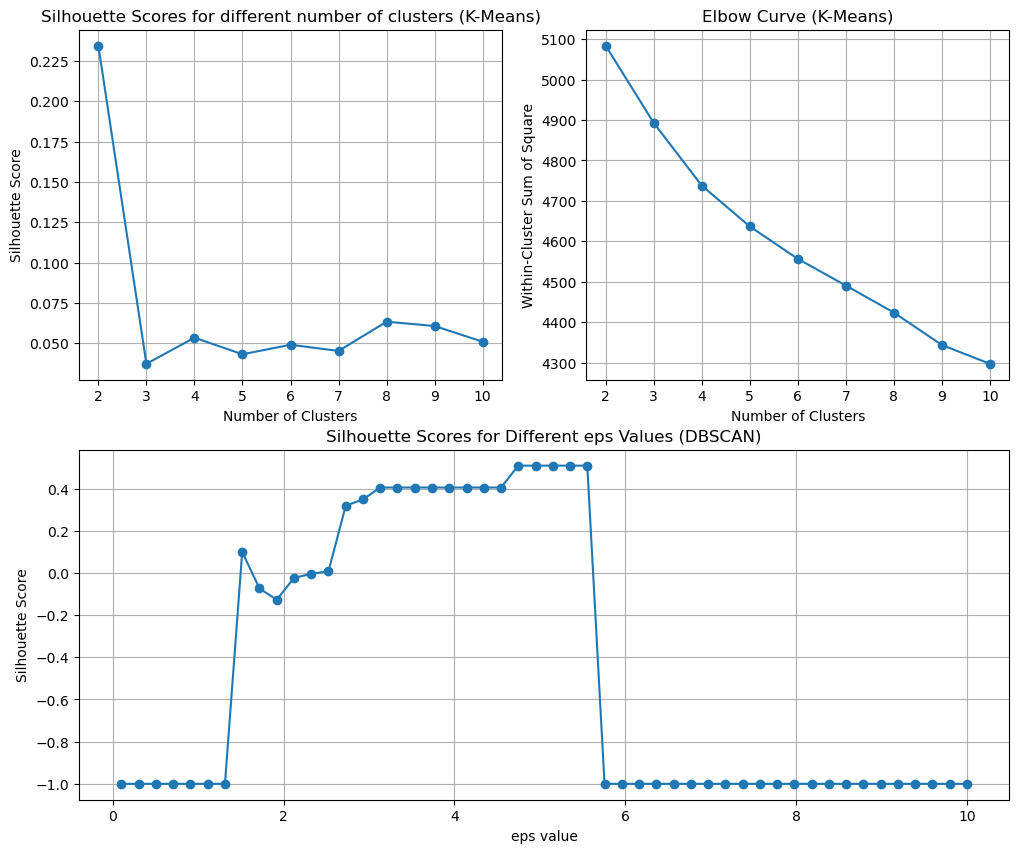

In [241]:
def random_walk(graph, start_node, walk_length, p=1.0, q=1.0):
    walk = [start_node]
    for _ in range(walk_length - 1):
        current = walk[-1]
        neighbors = list(graph.neighbors(current))
        # if not neighbors:
        #     break
        if len(walk) == 1:
            walk.append(random.choice(neighbors))
        else:
            prev = walk[-2]
            probabilities = []
            for neighbor in neighbors:
                if neighbor == prev:
                    probabilities.append(1.0 / p)
                elif graph.has_edge(neighbor, prev):
                    probabilities.append(1.0)
                else:
                    probabilities.append(1.0 / q)
            norm_prob = np.array(probabilities) / np.sum(probabilities)
            walk.append(np.random.choice(neighbors, p=norm_prob))
    return walk

# Step 3: Generate Random Walks
def generate_walks(graph, num_walks, walk_length):
    walks = []
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walks.append(random_walk(graph, node, walk_length))
    return walks

walks = generate_walks(G, num_walks=10, walk_length=80)

walks_str = [[str(node) for node in walk] for walk in walks]
model = Word2Vec(sentences=walks_str, vector_size=128, window=10, min_count=1, sg=1, workers=4, epochs=5)

# Getting node embeddings
node_embeddings_dict = {node: model.wv[str(node)] for node in G.nodes()}
# embedding_w2v = np.vstack(list(node_embeddings_dict.values()))

embedding_w2v = np.array([node_embeddings_dict[node] for node in G.nodes()])

hyperparam_search(embedding_w2v, 'node2vec')

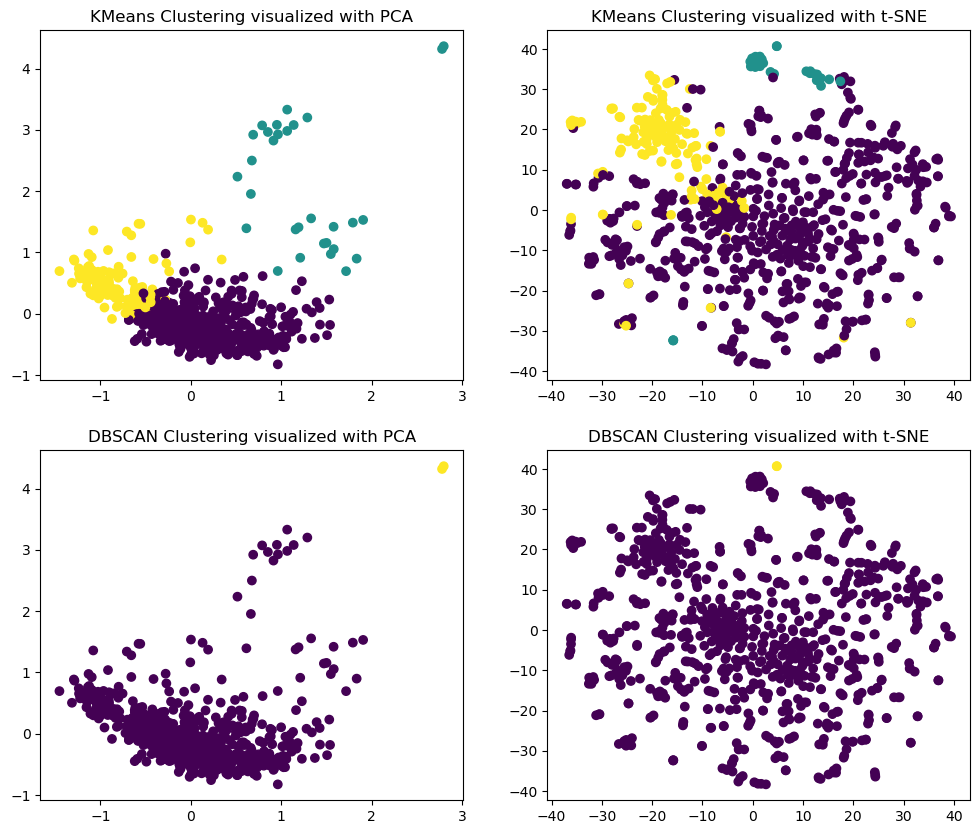

In [244]:
plot_results(3, 4.7469, embedding_w2v)

Hyperparameter search for spectral:
Best eps value is: 0.1 with silhouette score: 0.9803176637416209


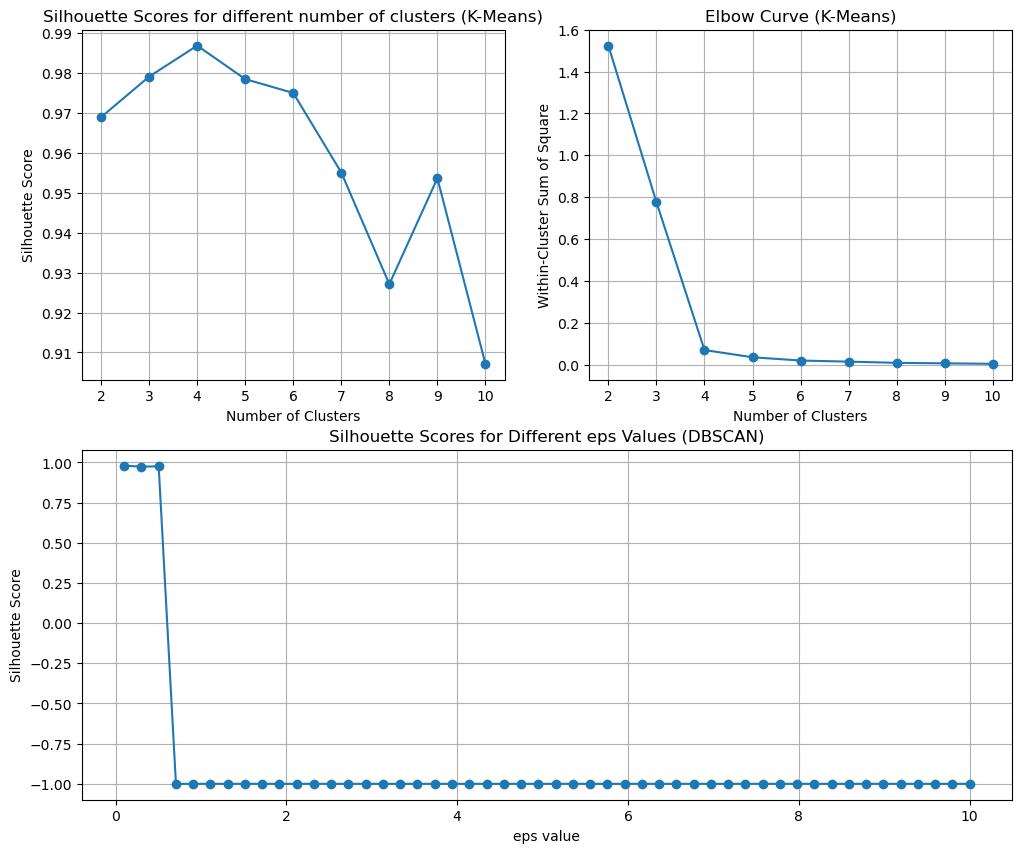

In [222]:
def spectral_embedding(G, num_components):
    # Compute the Laplacian matrix
    A = nx.to_scipy_sparse_array(G)
    
    # Calculate degree matrix
    degrees = np.array(A.sum(axis=1)).flatten()
    D = diags(degrees)
    
    L = D - A

    # Compute the eigenvectors corresponding to the smallest non-zero eigenvalues
    eigenvalues, eigenvectors = eigsh(L, k=num_components + 1, which='SM')
    
    # Skip the first eigenvector (eigenvalue = 0)
    return eigenvectors[:, 1:num_components + 1]

embedding_spectral = spectral_embedding(G, num_components=3)

hyperparam_search(embedding_spectral, 'spectral')

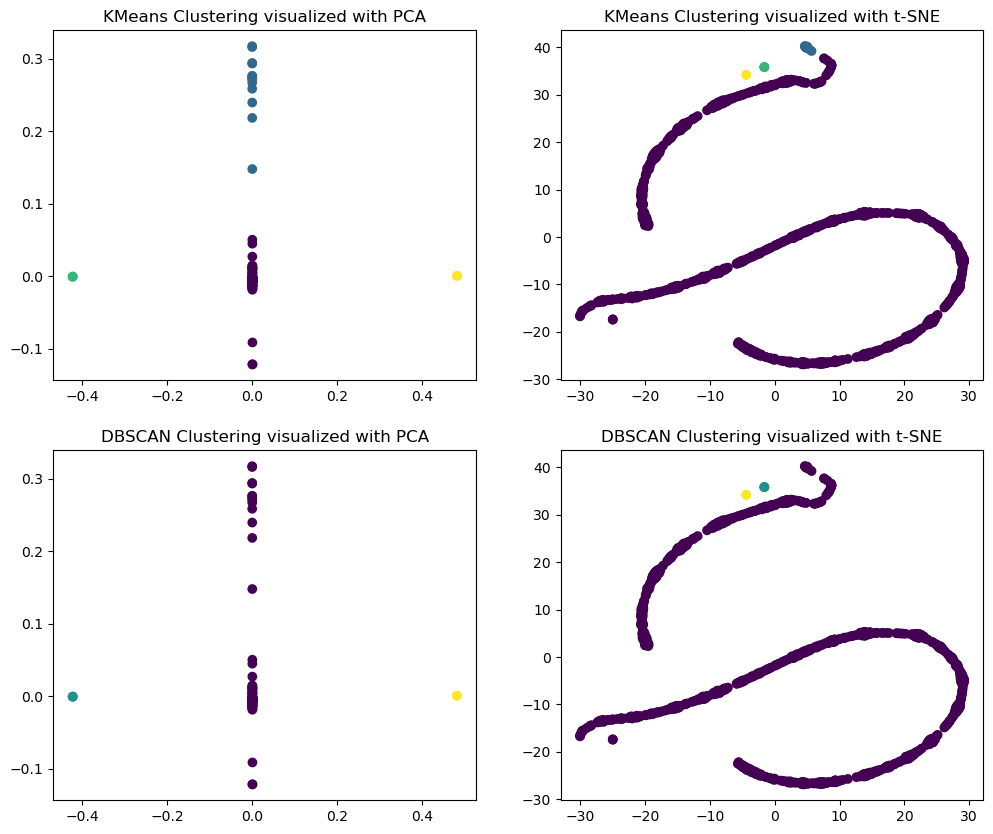

In [223]:
plot_results(4, 0.1, embedding_spectral)

Epoch 0, Loss: -0.2874448895454407
Epoch 20, Loss: -15.783553123474121
Epoch 40, Loss: -65.5810317993164
Epoch 60, Loss: -164.52056884765625
Epoch 80, Loss: -320.74530029296875
Epoch 100, Loss: -538.013427734375
Epoch 120, Loss: -817.8878173828125
Epoch 140, Loss: -1164.14599609375
Epoch 160, Loss: -1588.216796875
Epoch 180, Loss: -2089.829345703125
Hyperparameter search for GCN:
Best eps value is: 9.191836734693878 with silhouette score: 0.7365673184394836


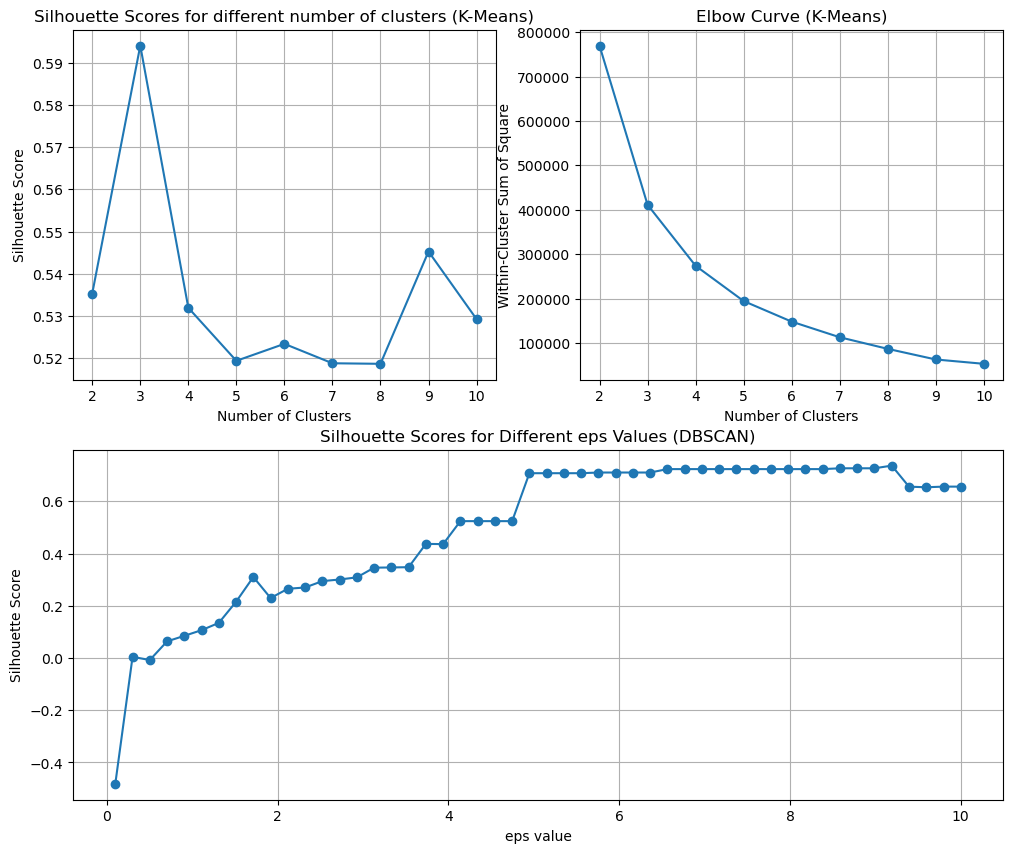

In [227]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        x = self.linear(x)
        return torch.spmm(adj, x)

class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GCN, self).__init__()
        self.layer1 = GCNLayer(in_features, hidden_features)
        self.layer2 = GCNLayer(hidden_features, out_features)

    def forward(self, x, adj):
        x = F.relu(self.layer1(x, adj))
        x = self.layer2(x, adj)
        return x

def normalize_adjacency(adj):
    adj = adj + torch.eye(adj.shape[0])  # Add self-loops
    degree = torch.diag(torch.sum(adj, dim=1))
    return torch.mm(torch.inverse(degree), adj)

features = torch.tensor(np.random.rand(G.number_of_nodes(), 5), dtype=torch.float32)
adj = nx.adjacency_matrix(G).todense()
adj = torch.tensor(adj, dtype=torch.float32)
adj = normalize_adjacency(adj)

# Initialize and train model
model = GCN(in_features=5, hidden_features=16, out_features=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(200):
    optimizer.zero_grad()
    embeddings = model(features, adj)
    loss = torch.mean(torch.sum(embeddings, dim=1))  # Placeholder loss
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

embedding_gcn = embeddings.cpu().detach().numpy()

hyperparam_search(embedding_gcn, 'GCN')

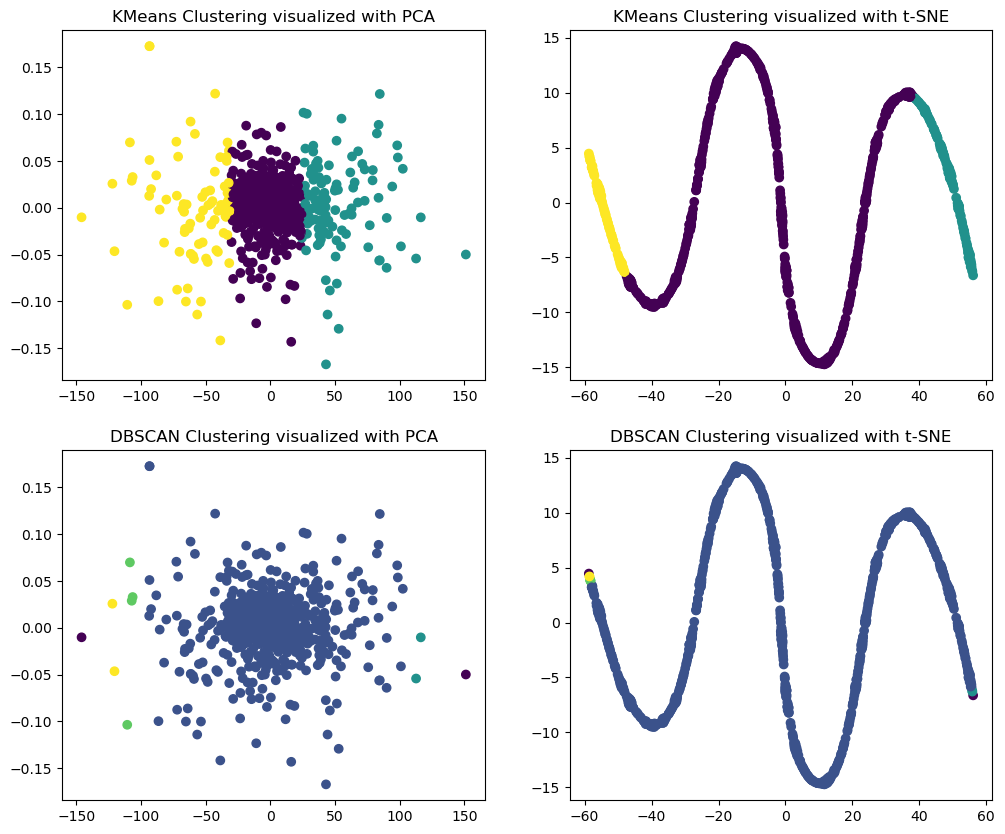

In [226]:
plot_results(3, 7.777, embedding_gcn)